In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rosbag
import pymap3d as pm
import numba as nb

from scipy.signal import savgol_filter
%matplotlib inline

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
def wrap_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

@nb.njit()
def to_euler(x, y, z, w):
    """Dari Coursera: Return as xyz (roll pitch yaw) Euler angles."""
    roll = np.arctan2(2 * (w * x + y * z), 1 - 2 * (x**2 + y**2))
    pitch = np.arcsin(2 * (w * y - z * x))
    yaw = np.arctan2(2 * (w * z + x * y), 1 - 2 * (y**2 + z**2))
    return np.array([roll, pitch, yaw])
# Compile the to_euler
_ = to_euler(1.5352300785980803e-15, -1.3393747145983517e-15, -0.7692164172827881, 0.638988343698562)

In [3]:
class get_data_from_bag(object):
    def __init__(self, path):
        self.bag = rosbag.Bag(path)
        self.cs = self._read_msg_from_topic('/control_signal', ['t', 'action_throttle', 'action_steer',
                                                                'error_lateral', 'error_yaw','error_speed',
                                                                'actual_x','actual_y','actual_yaw','actual_speed',
                                                                'ref_x', 'ref_y', 'ref_yaw', 'ref_curvature', 'ref_speed',
                                                                'wp_idx'])
        self.ar = self._read_msg_from_topic('/logging_arduino', ['t', 'steering_setpoint', 'steering_angle', 'throttle_voltage'])
        
    def _read_msg_from_topic(self, topic, columns_name):
        data = []
        for _, msg, _ in self.bag.read_messages(topics=[topic]):
            temp = []
            for name in columns_name:
                if name == 't':
                    temp.append(msg.header.stamp.to_sec())
                else:
                    nm = 'msg.' + name
                    temp.append(eval(nm))
            data.append(temp)
        return pd.DataFrame(data, columns = columns_name)

In [4]:
df = get_data_from_bag('Stanley With Throttle/LURUS_ERROR_BESAR.bag')

# TAMBAHAN

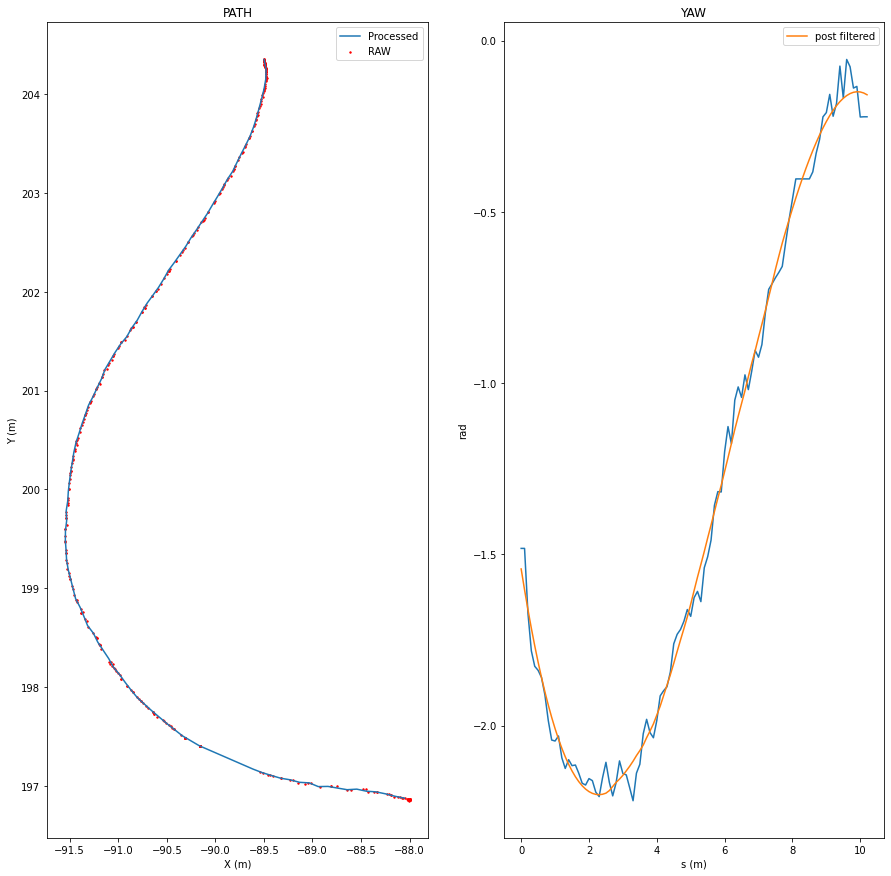

In [5]:
num_f = 51

dst = 0.1

X = np.copy(df.cs.actual_x)
Y = np.copy(df.cs.actual_y)
x = np.copy(df.cs.actual_x)
y = np.copy(df.cs.actual_y)
t = np.copy(df.cs.t)
XX = np.copy(df.cs.ref_x)
YY = np.copy(df.cs.ref_y)


wp_x = [X[0]]
wp_y = [Y[0]]
wp_xx = [XX[0]]
wp_yy = [YY[0]]
wp_t = [t[0]]
for i in range(1, X.shape[0]):
    dist = np.sqrt((X[i] - wp_x[-1])**2 + (Y[i] - wp_y[-1])**2)
    ddist = np.sqrt((XX[i] - wp_xx[-1])**2 + (YY[i] - wp_yy[-1])**2)
    while dist >= dst:
    #if dist >= dst:
        wp_x.append(wp_x[-1] + dst*(X[i] - wp_x[-1])/dist)
        wp_y.append(wp_y[-1] + dst*(Y[i] - wp_y[-1])/dist)
        wp_t.append(wp_t[-1] + dst*(t[i] - wp_t[-1])/dist)
        wp_xx.append(wp_xx[-1] + dst*(XX[i] - wp_xx[-1])/ddist)
        wp_yy.append(wp_yy[-1] + dst*(YY[i] - wp_yy[-1])/ddist)
        dist = np.sqrt((X[i] - wp_x[-1])**2 + (Y[i] - wp_y[-1])**2)
        ddist = np.sqrt((XX[i] - wp_xx[-1])**2 + (YY[i] - wp_yy[-1])**2)
wp_x = np.array(wp_x)
wp_y = np.array(wp_y)
wp_yaw = np.zeros_like(wp_x)
diffx = wp_x[2:] - wp_x[:-2]
diffy = wp_y[2:] - wp_y[:-2]
wp_yaw[1:-1] = np.arctan2(diffy, diffx)
wp_yaw[0] = wp_yaw[1]
wp_yaw[-1] = wp_yaw[-2]
wp_x_f = savgol_filter(wp_x, num_f, 3)
wp_y_f = savgol_filter(wp_y, num_f, 3)
wp_yaw_f = savgol_filter(np.unwrap(wp_yaw), num_f, 3)
act_yaw_dydx = np.copy(wp_yaw_f)

s = np.zeros(wp_x.shape[0])
for i in range(1, s.shape[0]):
    s[i] = s[i-1] + np.sqrt((wp_x[i] - wp_x[i-1])**2 + (wp_y[i] - wp_y[i-1])**2)

width = 15
height = 15
plt.figure(figsize=(width, height))

plt.subplot(1,2,1)
plt.plot(wp_x, wp_y, label='Processed')
plt.scatter(x, y, color='red',s=2., label='RAW')
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.legend()
plt.title("PATH")

plt.subplot(1,2,2)
plt.plot(s, wp_yaw)
plt.plot(s, wp_yaw_f, label='post filtered')
plt.title("YAW")
plt.xlabel('s (m)')
plt.ylabel('rad')
plt.legend()

#plt.savefig('waypoints.png', dpi=600, transparent=True)
plt.show()

In [6]:
ref_yaw_dydx = np.zeros_like(act_yaw_dydx)
ref_yaw_dydx[:] = np.arctan2(df.cs.ref_y.values[-1] - df.cs.ref_y.values[0], df.cs.ref_x.values[-1] - df.cs.ref_x.values[0])
e_yaw_gt = np.interp(df.cs.t, wp_t, wrap_angle(ref_yaw_dydx - act_yaw_dydx))

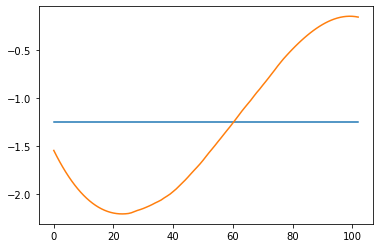

In [7]:
plt.plot(ref_yaw_dydx)
plt.plot(act_yaw_dydx)

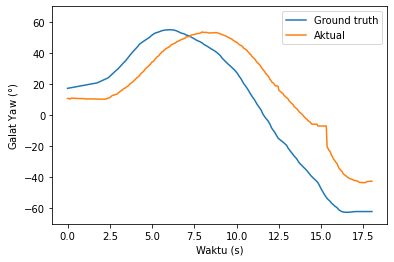

In [8]:
plt.plot(df.cs.t - df.cs.t[0], e_yaw_gt*180/np.pi, label='Ground truth')
plt.plot(df.cs.t - df.cs.t[0], 180/np.pi*df.cs.error_yaw, label='Aktual')
plt.legend()
plt.xlabel("Waktu (s)")
plt.ylabel(r"Galat Yaw $(\degree)$")
plt.ylim(-70., 70.)
plt.savefig('img/analisis_kegagalan_e_yaw.png', transparent=True, dpi=600)
plt.show()

In [9]:
lim = [-28., 35.]
steer_actual = (df.cs.error_yaw + np.arctan2(1.0 * df.cs.error_lateral, 1.0 + df.cs.actual_speed))*(180./np.pi)
steer_actual[steer_actual < min(lim)] = min(lim)
steer_actual[steer_actual > max(lim)] = max(lim)
steer_gt = (e_yaw_gt + np.arctan(1.0 * df.cs.error_lateral / (1.0 + df.cs.actual_speed)))*(180./np.pi)
steer_gt[steer_gt < min(lim)] = min(lim)
steer_gt[steer_gt > max(lim)] = max(lim)

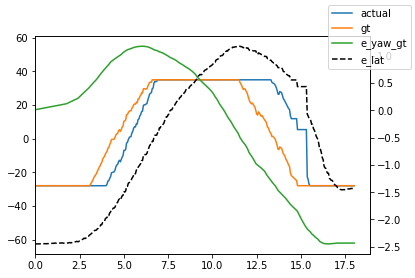

In [10]:
fig, ax1 = plt.subplots()
ax1.plot(df.cs.t - df.cs.t[0], steer_actual, label='actual')
ax1.plot(df.cs.t - df.cs.t[0], steer_gt, label='gt')
ax1.plot(df.cs.t - df.cs.t[0], e_yaw_gt*180/np.pi, label='e_yaw_gt')
# ax1.plot(df.ar.t - df.cs.t[0], -df.ar.steering_angle, label='arduino')
ax2 = ax1.twinx()
ax2.plot(df.cs.t - df.cs.t[0], df.cs.error_lateral, color='black', linestyle='--', label='e_lat')
plt.xlim(0., None)
fig.legend()
plt.show()